# 다양한 데이터 분류기 만들기
---
<br />

### 목표
`scikit-learn`에서 제공하는 toy database 중 서로 다른 세가지(load_digits, load_wine, load_breast_cancer) 데이터 셋과 다양한 모델*(Decision Tree, Random Forest, SVM, SGD Classifier, Logistic Regression)*을 활용하여 다양한 분류기를 만들어 본다.

## 0. 모델 학습과 평가 함수 정의
본 프로젝트에서는 다양한 데이터를 동일한 모델들을 사용하여 학습을 하고 평가를 하는 공통적인 과정이 반복적으로 등장한다. 이를 위하여 5개의 분류 모델을 학습하여 반환하는 함수와 모델들을 평가하여 결과를 출력하는 함수 두 가지를 사전에 작성하고자 한다.

In [1]:
# import package
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import pandas as pd

import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 54

* `get_trained_models` : train 데이터를 입력받아, 학습된 서로 다른 5개의 모델을 반환한다.

In [2]:
def get_trained_models(random_state, X_train, y_train):
    models = {}
    
    # Decision Tree
    decision_tree_model = DecisionTreeClassifier(random_state=random_state)
    decision_tree_model.fit(X_train, y_train)
    print("Training [Decision Tree] completed !")
    models['Decision Tree'] = decision_tree_model
    
    # Random Forest
    random_forest_model = RandomForestClassifier(random_state=random_state)
    random_forest_model.fit(X_train, y_train)
    print("Training [Random Forest] completed !")
    models['Random Forest'] = random_forest_model
    
    # SVM
    svm_model = svm.SVC()
    svm_model.fit(X_train, y_train)
    print("Training [SVC] completed !")
    models['SVC'] = svm_model
    
    # SGD Classifier
    sgd_model = SGDClassifier()
    sgd_model.fit(X_train, y_train)
    print("Training [SGD] completed !")
    models['SGD'] = sgd_model
    
    # Logistic Regression
    logistic_model = LogisticRegression(solver='lbfgs', max_iter=10000)
    logistic_model.fit(X_train, y_train)
    print("Training [Logistic Regression] completed !")
    models['Logistic Regression'] = logistic_model
    
    return models

* `get_models_evaluation` : test 데이터와 학습된 모델을 입력받아 모델에 대한 평가지표(pandas.DataFrame)을 반환한다.

In [3]:
def get_models_evaluation(models, X_test, y_test):
    evaluations = {}
    df_indexs = ['accuracy', 'precision score(macro avg)', 'precision score(weighted avg)',
                 'recall score(macro avg)', 'recall score(weighted avg)',
                 'f1 score(macro avg)', 'f1 score(weighted avg)']
    for model_name in models.keys():
        y_pred = models[model_name].predict(X_test)

        evaluations[model_name] = [
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred, average='macro'),
            precision_score(y_test, y_pred, average='weighted'),
            recall_score(y_test, y_pred, average='macro'),
            recall_score(y_test, y_pred, average='weighted'),
            f1_score(y_test, y_pred, average='macro'),
            f1_score(y_test, y_pred, average='weighted')
        ]

        evaluation_df = pd.DataFrame(evaluations, index=df_indexs)    
    return evaluation_df

## 1. load_digits를 이용한 손글씨 분류
---
### (1) 필요한 모듈 import 하기

In [4]:
# 위에서 대부분의 package를 추가하였으므로 손글씨를 불러들여오는 load_digits만 추가하였다
from sklearn.datasets import load_digits

### (2) 데이터 준비
`load_digits` 메서드를 활용하여 데이터를 불러온다.

In [5]:
digits = load_digits()
dir(digits)

['DESCR', 'data', 'images', 'target', 'target_names']

label : 0(0)
array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])


<Figure size 432x288 with 0 Axes>

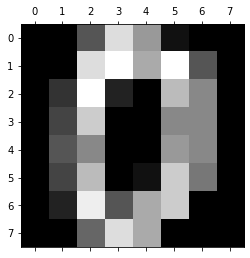

In [6]:
# 데이터가 잘 불러와 졌는지 확인
print("label : {}({})".format(digits.target[0], digits.target_names[digits.target[0]]))

pprint.pprint(digits.data[0].reshape(8,8))

plt.gray()
plt.matshow(digits.images[0])
plt.show()

출력된 배열과 이미지의 모양이 label과 같은 0임을 확인하여 데이터가 잘 불러와졌음을 확인 할 수 있었다.

### (3) 데이터 이해하기

In [7]:
digits_data = digits.data
digits_label = digits.target

In [8]:
digits.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

데이터 문서에 따르면 `load_digits`으로 불러들인 데이터의 각 멤버 변수를 다음과 같은 의미를 가진다.
* data : 8x8 이미지 데이터를 평탄화한 배열의 집합으로, 총 1797개의 손글씨 이미지 데이터이다. 모델에 사용되는 **feature data**가 된다.
* feature_names : 데이터의 column 명으로 픽셀의 인덱스를 의미하고 있다.
* images : raw 이미지 데이터이다. 이를 편탄화 시킨것이 data이다.
* target : data에 대응되는 값으로 해당 손글씨가 어떤 숫자인지를 저장하고 있다. 모델에 사용되는 **label data**가 된다.
* target_names : target이 의미하는 실제 값으로 이 데이터에서는 인덱스와 같은 숫자 값이 된다.


### (4) train, test 데이터 분리


In [10]:
digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(
    digits_data, 
    digits_label, 
    test_size=0.2, 
    random_state=7)

### (5) 다양한 모델로 학습시켜보기

In [11]:
models = get_trained_models(39, digits_X_train, digits_y_train)

Training [Decision Tree] completed !
Training [Random Forest] completed !
Training [SVC] completed !
Training [SGD] completed !
Training [Logistic Regression] completed !


###  (6) 모델을 평가해 보기

In [12]:
evaludation_dp = get_models_evaluation(models, digits_X_test, digits_y_test)
evaludation_dp

,Decision Tree,Random Forest,SVC,SGD,Logistic Regression
accuracy,0.850000,0.961111,0.988889,0.944444,0.952778
precision score(macro avg),0.856277,0.961940,0.988788,0.945640,0.952326
precision score(weighted avg),0.853476,0.963030,0.989512,0.945954,0.955294
recall score(macro avg),0.855737,0.963093,0.989898,0.942848,0.953345
recall score(weighted avg),0.850000,0.961111,0.988889,0.944444,0.952778
f1 score(macro avg),0.853488,0.960931,0.989024,0.943734,0.951512
f1 score(weighted avg),0.849173,0.960416,0.988877,0.944726,0.952886


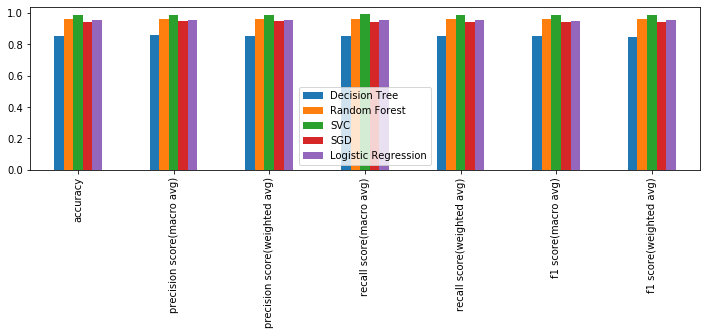

In [13]:
evaludation_dp.plot(kind="bar", figsize=(12,3))

숫자를 판별하는 분류기를 평가하는 것에 있어서 Recall 값과 Precision 둘 중 더 중요한 값을 가리기가 모호하기 때문에 accuracy와 F1 socre 값을 이용하여 모델을 평가하고자 한다. 테스트 결과 두 지표에서 모두 *SVM* 모델이 가장 좋은 성능을 보여주고 있음을 확인할 수 있었다.

## 2. load_wind를 이용한 와인 분류
---
### (1) 필요한 모듈 import 하기

In [14]:
from sklearn.datasets import load_wine

### (2) 데이터 준비
`load_wine` 메서드를 활용하여 데이터를 불러온다.

In [15]:
wine = load_wine()
dir(wine)

['DESCR', 'data', 'feature_names', 'target', 'target_names']

In [16]:
# 데이터가 잘 불러와 졌는지 확인
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


### (3) 데이터 이해하기

In [17]:
wine_data = wine.data
wine_label = wine.target

In [18]:
wine.data[0], len(wine.data), wine.feature_names

(array([1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
        3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
        1.065e+03]),
 178,
 ['alcohol',
  'malic_acid',
  'ash',
  'alcalinity_of_ash',
  'magnesium',
  'total_phenols',
  'flavanoids',
  'nonflavanoid_phenols',
  'proanthocyanins',
  'color_intensity',
  'hue',
  'od280/od315_of_diluted_wines',
  'proline'])

In [19]:
wine.target_names, wine.target

(array(['class_0', 'class_1', 'class_2'], dtype='<U7'),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2]))

In [20]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

이번에 다루는 데이터는 와인의 화학 조성을 사용하여 와인의 종류를 예측하기 위한 데이터이다. 데이터 문서에 따르면 `load_wine`으로 불러들인 데이터의 각 멤버 변수는 다음 같은 의미를 가진다.
* data : 숫자로 된 와인 화학 조성을 모아 놓은 데이터로 178개의 데이터의 모음이다. 모델에서 사용되는 **feature data**가 된다. 포함하고 있는 와인 화학 조성은 다음과 같다.
    * Alcohol : 알콜
    * Malic acid : 말산
    * Ash : 회분
    * Alcalinity of ash : 회분의 알라리도  
    * Magnesium : 마그네슘
    * Total phenols : 총 폴리페놀
    * Flavanoids : 플라보노이드 폴리페놀
    * Nonflavanoid phenols : 비 플라보노이드 폴리페놀
    * Proanthocyanins : 프로안토시아닌
    * Color intensity : 색상의 강도
    * Hue : 색상
    * OD280/OD315 of diluted wines : 희석 와인의 OD280/OD315 비율
    * Proline : 프롤린
* feature_names : 데이터의 column 명으로 위에서 살펴본 와인 화학 조성을 담고 있다.
    * ['alcohol','malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
* target : 와인의 종류를 0~2로 표현하고 있다. 모델에 사용되는 **label data**가 된다.
* target_names : target이 의미하는 실제 값을 담고 있다. target가 0이면 class_0, 1이면 class_1, 2이면 class_2를 의미한다.

### (4) train, test 데이터 분리

In [21]:
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine_data, 
    wine_label, 
    test_size=0.2, 
    random_state=37)

### (5) 다양한 모델로 학습시켜보기

In [22]:
models = get_trained_models(37, wine_X_train, wine_y_train)

Training [Decision Tree] completed !
Training [Random Forest] completed !
Training [SVC] completed !
Training [SGD] completed !
Training [Logistic Regression] completed !


### (6) 모델을 평가해 보기

In [23]:
evaludation_dp = get_models_evaluation(models, wine_X_test, wine_y_test)
evaludation_dp

,Decision Tree,Random Forest,SVC,SGD,Logistic Regression
accuracy,0.861111,0.972222,0.555556,0.444444,0.888889
precision score(macro avg),0.867965,0.974359,0.530525,0.604598,0.905556
precision score(weighted avg),0.867965,0.974359,0.546195,0.637931,0.900926
recall score(macro avg),0.876984,0.976190,0.540476,0.447619,0.895238
recall score(weighted avg),0.861111,0.972222,0.555556,0.444444,0.888889
f1 score(macro avg),0.866178,0.974321,0.533563,0.367344,0.894137
f1 score(weighted avg),0.857713,0.972263,0.548941,0.366418,0.888514


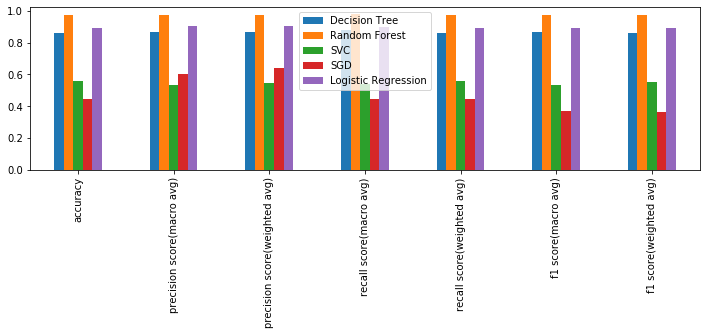

In [24]:
evaludation_dp.plot(kind="bar", figsize=(12,3))

와인을 분류하는 분류기를 평가하는 기준으로 Recall 값과 Precision 두가지의 값 중 어느 것에 더 비중을 줄 지 모호하기 때문에 두 값의 조화평균인 F1 score와 accuarcy를 기준으로 삼기로 하였다. 테스트 결과 두 지표에서 모두 *Random Forest*가 가장 좋은 성능을 보여주고 있다.

## 3. load_breast_cancer를 이용한 유방암 진단
---
### (1) 필요한 모듈 import 하기

In [25]:
from sklearn.datasets import load_breast_cancer

### (2) 데이터 준비
`load_breast_cancer` 메서드를 활용하여 데이터를 불러온다.

In [26]:
breast_cancer = load_breast_cancer()
dir(breast_cancer)

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']

In [27]:
# 데이터가 잘 불러와 졌는지 확인
breast_cancer_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### (3) 데이터 이해하기

In [28]:
breast_cancer_data = breast_cancer.data
breast_cancer_label = breast_cancer.target

In [29]:
breast_cancer.data[0], len(breast_cancer.data), breast_cancer.feature_names

(array([1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01]),
 569,
 array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error',
        'fractal dimension error', 'worst radius', 'worst texture',
        'worst perimeter', 'worst area', 'worst smoothness',
        'worst compactness', 'worst concavity', 'worst concave points',
        'worst symme

In [30]:
breast_cancer.target_names, breast_cancer.target

(array(['malignant', 'benign'], dtype='<U9'),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0

In [31]:
breast_cancer.filename

'/home/aiffel/anaconda3/lib/python3.7/site-packages/sklearn/datasets/data/breast_cancer.csv'

In [32]:
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

이번 데이터는 유방암 진단 사진으로부터 측정한 종양의 특징값을 사용하여 종양이 양성인지 악성인지를 판별하는 데이터이다. 문서에 따르면 `load_breast_cancer`으로 불러들인 데이터의 각 멤버 변수는 다음 같은 의미를 가진다.
* data : 유방한 진단 사진에 대한 데이터의 모음이다. 아래 항목들이 mean, error, worst 세가지로 각각 분화되어 총 30개의 멤버 변수로 데이터가 구성되어 있다. 이 값이 모델에서 사용되는 **feature data**가 된다.
    * radius : 중심에서 주변지점까지의 거리 평균
    * texture : 회색조 값의 표준 편자
    * perimeter : 둘레
    * area : 구역
    * smoothness : 반경 길이의 국부적 변동
    * compactness : $ (둘레^2 / 면적) - 0.1 $
    * concavity : 윤곽의 오목한 부분의 심각도
    * concave points : 윤곽의 오목한 부분의 수
    * symmetry : 대칭
    * fractal dimension : coastline approximation - 1
* feature_names : 데이터의 column 명으로 위에서 살펴본 항목들을 담고 있다.
    * ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error',
        'fractal dimension error', 'worst radius', 'worst texture',
        'worst perimeter', 'worst area', 'worst smoothness',
        'worst compactness', 'worst concavity', 'worst concave points',
        'worst symmetry', 'worst fractal dimension']
* target : 유방암 진단 결과를 0과 1로 표현하고 있다. 모델에 사용되는 **label data**가 된다.
* target_naems : target이 의미하는 실제 값을 담고 있다. target이 0이면 malignant(악성),  1이면 benign(양성)이다.
* filename : 데이터가 저장된 위치를 담고 있다.

### (4) train, test 데이터 분리

In [33]:
breast_cancer_X_train, breast_cancer_X_test, breast_cancer_y_train, breast_cancer_y_test = train_test_split(
    breast_cancer_data, 
    breast_cancer_label, 
    test_size=0.2, 
    random_state=17)

### (5) 다양한 모델로 학습시켜보기

In [34]:
models = get_trained_models(39, breast_cancer_X_train, breast_cancer_y_train)

Training [Decision Tree] completed !
Training [Random Forest] completed !
Training [SVC] completed !
Training [SGD] completed !
Training [Logistic Regression] completed !


### (6) 모델을 평가해 보기

유방암 데이터는 양성을 음성으로 예측하지 않아햐 하므로 악성에 대한 recall 값이 중요하다. 따라서 이전 데이터의 경우와 다르게 이번에는 각 모델의 label=0인 데이터에 대한 recall 값만을 수집하여 비교하고자 한다.

In [35]:
recalls = []
index = []

for model_name in models.keys():
    y_pred = models[model_name].predict(breast_cancer_X_test)
    index.append(model_name)
    recalls.append(precision_score(breast_cancer_y_test, y_pred, pos_label=0))

evaludation_dp = pd.DataFrame(recalls, index=index, columns=['recall'])
evaludation_dp

,recall
Decision Tree,0.916667
Random Forest,0.923077
SVC,0.969697
SGD,1.000000
Logistic Regression,0.900000


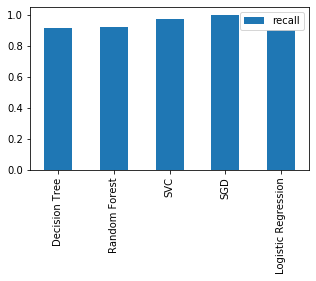

In [36]:
evaludation_dp.plot(kind="bar", figsize=(5,3))

 테스트 결과 두 지표에서 모두 *Random Forest*가 가장 좋은 성능을 보여주고 있다.

## 결론
---
이번 프로젝트는 다양한 데이터를 활용하여 분류 모델을 학습시키고 예측 결과를 분석해 내는 일련에 과정에 익숙해지는 것을 목표로하였다. 기초 학습 과정에서 오차행렬의 의미를 정확히 이해하는 것에 어려움이 있었지만, 다행이 여러자료를 통하여 이에 대한 개념을 확실히 할 수 있었다. 다만 아직 데이터 별로 어떤 평가지표를 기준으로 하여 평가를 내릴지에 대한 판단이 명확하지 않다. 이에 대해서는 다양한 데이터들을 다른 사람들이 어떻게 분석하는지를 더 학습하여 매꾸어 나아가야 할 것 같다. 추가로 프로젝트에 다섯가지 분류모델이 사용 되었는데 그 중 Desision Tree와 Random Forest를 제외한 나머지 세개의 모델에 대해서는 이해가 부족하여 이 부분을 다시 공부해야 한다는 개인적인 과제가 생겼다.

### ref
* [pprint : 쉽고 예쁘게 출력하기](https://pythonkim.tistory.com/91)
* [마이크로 평균(Micro-average), 매크로 평균(Macro-average) 이란 무엇인가?](https://unlimitedpower.tistory.com/entry/IR-마이크로-평균Micro-average-매크로-평균Macro-average-이란-무엇인가)
* [분류 성능평가](https://datascienceschool.net/03%20machine%20learning/09.04%20%EB%B6%84%EB%A5%98%20%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80.html)
* [pandas.Dataframe – 1편 객체 생성 및 row 추가방법](https://ldgeao99.tistory.com/6?category=820980)